In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# read the csv files and plot the data
df_AT = pd.read_csv(r"D:\VScode\van2015_repeat\VOSTOK_data\AT.csv")
df_CO2 = pd.read_csv(r"D:\VScode\van2015_repeat\VOSTOK_data\CO2.csv")
# df_CH4 = pd.read_csv(r"D:\VScode\van2015_repeat\VOSTOK_data\CH4.csv")
# df_inso = pd.read_csv(r"D:\VScode\van2015_repeat\VOSTOK_data\insolation.csv")

# print information
print(df_AT.info())
print(df_CO2.info())
# print(df_CH4.info())
# print(df_inso.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399 entries, 0 to 398
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     399 non-null    int64  
 1   AT      399 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 6.4 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399 entries, 0 to 398
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     399 non-null    int64  
 1   CO2     399 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 6.4 KB
None


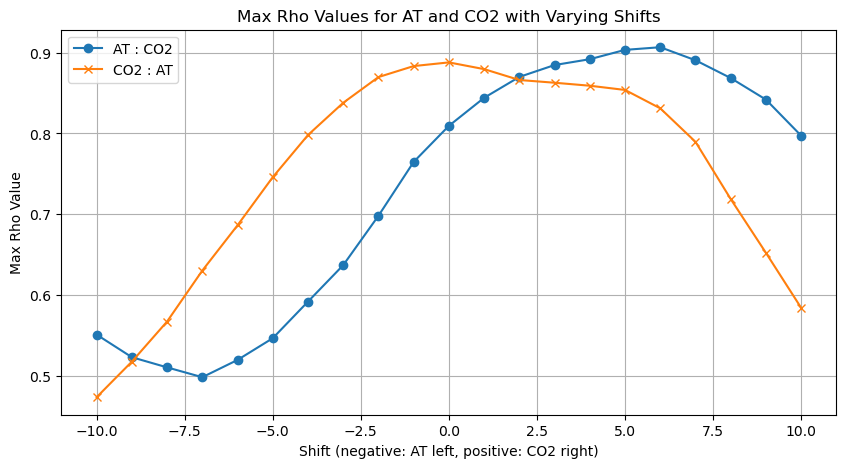

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyEDM import CCM

def plot_rho_vs_shift(df_AT, df_CO2, sub_length=120, lib_size=90, 
                      shift_range=range(-10, 11), tau=1, E=2):
    # Merge the two datasets on 'age'
    df = pd.merge(df_AT, df_CO2, on='age')
    
    n_total = len(df)
    
    # Select a random contiguous sub-sample of sub_length points.
    start = np.random.randint(0, n_total - sub_length + 1)
    sub_df = df.iloc[start:start+sub_length].reset_index(drop=True)
    
    forward_rho_values = []
    reverse_rho_values = []
    
    # Loop over shift values.
    for shift in shift_range:
        # Forward shift: shift the AT column relative to CO2
        temp_df = sub_df.copy()
        temp_df['AT'] = sub_df['AT'].shift(shift)
        temp_df.dropna(inplace=True)  # Drop rows with NaN (caused by shifting)
        
        # CCM from AT to CO2
        try:
            ccm_forward = CCM(
                dataFrame=temp_df,
                E=E,
                tau=tau,
                columns='AT',
                target='CO2',
                libSizes=str(lib_size),
                sample=100,
                random=False,
                replacement=False,
                Tp=0
            )
            forward_rho_values.append(ccm_forward['AT:CO2'].iloc[-1])  # Collect the last rho value
        except Exception as e:
            forward_rho_values.append(np.nan)  # In case CCM fails (e.g., too few points)

        # Reverse shift: shift the CO2 column relative to AT
        temp_df = sub_df.copy()
        temp_df['CO2'] = sub_df['CO2'].shift(shift)
        temp_df.dropna(inplace=True)
        
        try:
            ccm_reverse = CCM(
                dataFrame=temp_df,
                E=E,
                tau=tau,
                columns='CO2',
                target='AT',
                libSizes=str(lib_size),
                sample=100,
                random=False,
                replacement=False,
                Tp=0
            )
            reverse_rho_values.append(ccm_reverse['CO2:AT'].iloc[-1])
        except Exception as e:
            reverse_rho_values.append(np.nan)

    # Plot rho values against shift values
    plt.figure(figsize=(10, 5))
    plt.plot(list(shift_range), forward_rho_values, label='AT : CO2', marker='o')
    plt.plot(list(shift_range), reverse_rho_values, label='CO2 : AT', marker='x')
    plt.xlabel('Shift (negative: AT left, positive: CO2 right)')
    plt.ylabel('Max Rho Value')
    plt.title('Max Rho Values for AT and CO2 with Varying Shifts')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_rho_vs_shift(df_AT, df_CO2, sub_length=300, lib_size=100, shift_range=range(-10, 11), tau=2, E=4)


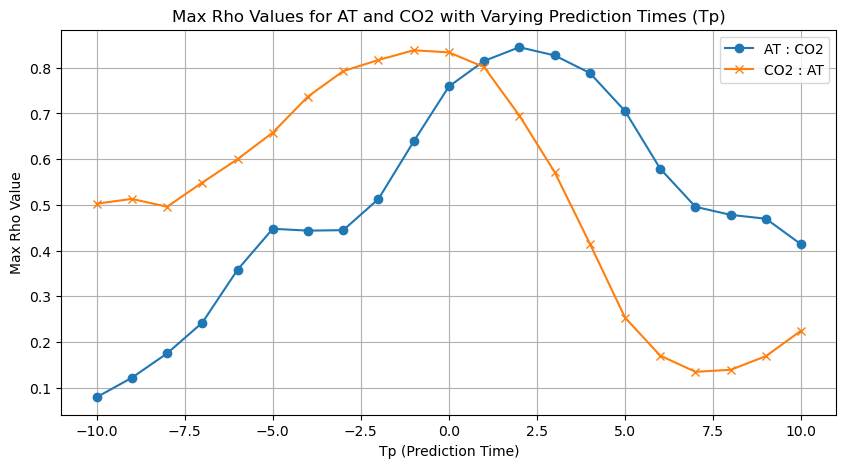

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyEDM import CCM

def plot_rho_vs_Tp(df_AT, df_CO2, sub_length=120, lib_size=90, Tp_range=range(-10, 11), tau=1, E=2):
    # Merge the two datasets on 'age'
    df = pd.merge(df_AT, df_CO2, on='age')
    # Rename 'age' to 'Time' (pyEDM expects a Time column)
    df = df.rename(columns={'age': 'Time'})
    
    n_total = len(df)
    
    # Select a random contiguous sub-sample of sub_length points.
    start = np.random.randint(0, n_total - sub_length + 1)
    sub_df = df.iloc[start:start+sub_length].reset_index(drop=True)
    
    forward_rho_values = []
    reverse_rho_values = []
    
    # Loop over Tp values.
    for Tp in Tp_range:
        # CCM: AT -> CO2
        ccm_forward = CCM(
            dataFrame=sub_df,
            E=E,
            tau=tau,
            columns='AT',    # predictor
            target='CO2',   # target
            libSizes=str(lib_size),  
            sample=100,
            random=False,
            replacement=False,
            Tp=Tp
        )
        forward_rho_values.append(ccm_forward['AT:CO2'].iloc[-1])  # Collect the last rho value
        
        # CCM: CO2 -> AT
        ccm_reverse = CCM(
            dataFrame=sub_df,
            E=E,
            tau=tau,
            columns='CO2',   # predictor
            target='AT',    # target
            libSizes=str(lib_size),
            sample=100,
            random=False,
            replacement=False,
            Tp=Tp
        )
        reverse_rho_values.append(ccm_reverse['CO2:AT'].iloc[-1])  # Collect the last rho value

    # Plotting the results
    plt.figure(figsize=(10, 5))
    plt.plot(list(Tp_range), forward_rho_values, label='AT : CO2', marker='o')
    plt.plot(list(Tp_range), reverse_rho_values, label='CO2 : AT', marker='x')
    plt.xlabel('Tp (Prediction Time)')
    plt.ylabel('Max Rho Value')
    plt.title('Max Rho Values for AT and CO2 with Varying Prediction Times (Tp)')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_rho_vs_Tp(df_AT, df_CO2, sub_length=120, lib_size=90, Tp_range=range(-10, 11), tau=1, E=2)


In [ ]:
import pandas as pd
import plotly.express as px
import plotly.io as pio

# Set the default renderer to 'vscode' so plots display inline in VS Code.
pio.renderers.default = "vscode"

# Create an interactive line plot of AT vs age.
fig = px.line(df_AT, x='age', y='AT', title='AT vs Age')

# Display the figure.
fig.show()


In [24]:
df_CO2

,age,CO2
0,398000,284.700000
1,397000,284.700000
2,396000,279.100000
3,395000,267.810809
4,394000,265.339087
...,...,...
394,4000,267.597266
395,3000,271.626043
396,2000,274.912701
397,1000,275.810171


In [23]:
df_AT

,age,AT
0,398000,-0.255625
1,397000,-0.059487
2,396000,-1.364348
3,395000,-0.550213
4,394000,-0.528750
...,...,...
394,4000,-4.210263
395,3000,-2.990189
396,2000,-2.384293
397,1000,-2.076076


In [30]:
# filp the df_AT and df_CO2 upside down and reset the index
df_AT = df_AT[::-1].reset_index(drop=True)
df_CO2 = df_CO2[::-1].reset_index(drop=True)

In [31]:
df_AT

,age,AT
0,0,-1.677747
1,1000,-2.076076
2,2000,-2.384293
3,3000,-2.990189
4,4000,-4.210263
...,...,...
394,394000,-0.528750
395,395000,-0.550213
396,396000,-1.364348
397,397000,-0.059487


In [32]:
df_CO2

,age,CO2
0,0,276.707642
1,1000,275.810171
2,2000,274.912701
3,3000,271.626043
4,4000,267.597266
...,...,...
394,394000,265.339087
395,395000,267.810809
396,396000,279.100000
397,397000,284.700000


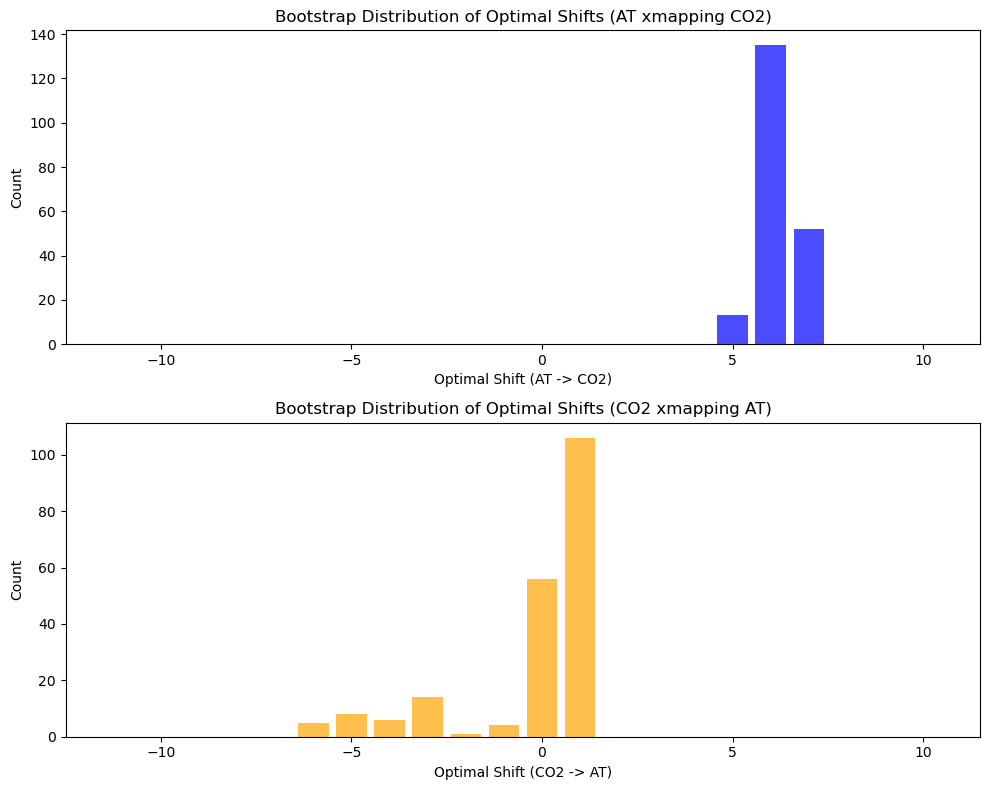

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyEDM import CCM

def bootstrap_ccm_shift(df_AT, df_CO2, n_boot=200, sub_length=120, lib_size=90, 
                          shift_range=range(-10, 11), tau=1, E=2):
    # Merge the two datasets on 'age'
    df = pd.merge(df_AT, df_CO2, on='age')
    # Rename 'age' to 'Time' (pyEDM expects a Time column)
    df = df.rename(columns={'age': 'Time'})
    
    n_total = len(df)
    forward_shifts = []
    reverse_shifts = []
    
    shift_list = list(shift_range)
    
    # Bootstrap iterations.
    for i in range(n_boot):
        # Select a random contiguous sub-sample of sub_length points.
        start = np.random.randint(0, n_total - sub_length + 1)
        sub_df = df.iloc[start:start+sub_length].reset_index(drop=True)
        
        forward_rho_shifts = []
        reverse_rho_shifts = []
        
        # Loop over shift values.
        for shift in shift_list:
            # For forward test: shift the AT column relative to CO2.
            temp_df = sub_df.copy()
            temp_df['AT'] = sub_df['AT'].shift(shift)
            # Drop rows with NaN (caused by shifting)
            temp_df = temp_df.dropna().reset_index(drop=True)
            # Run CCM with Tp fixed at 0.
            try:
                ccm_forward = CCM(
                    dataFrame   = temp_df,
                    E           = E,
                    tau         = tau,
                    columns     = 'AT',    # predictor
                    target      = 'CO2',   # target
                    libSizes    = str(lib_size),
                    sample      = 100,
                    random      = False,
                    replacement = False,
                    Tp          = 0
                )
                forward_rho_shifts.append(ccm_forward.iloc[-1]['AT:CO2'])
            except Exception as e:
                # In case CCM fails (e.g. too few points), append a NaN.
                forward_rho_shifts.append(np.nan)
            

            temp_df = sub_df.copy()
            temp_df['CO2'] = sub_df['CO2'].shift(shift)
            temp_df = temp_df.dropna().reset_index(drop=True)
            try:
                ccm_reverse = CCM(
                    dataFrame   = temp_df,
                    E           = E,
                    tau         = tau,
                    columns     = 'CO2',   # predictor
                    target      = 'AT',    # target
                    libSizes    = str(lib_size),
                    sample      = 1,
                    random      = False,
                    replacement = False,
                    Tp          = 0
                )
                reverse_rho_shifts.append(ccm_reverse.iloc[-1]['CO2:AT'])
            except Exception as e:
                reverse_rho_shifts.append(np.nan)
        
        # Determine the shift that gives the maximum CCM skill (ignoring NaNs).
        forward_rho_shifts = np.array(forward_rho_shifts)
        reverse_rho_shifts = np.array(reverse_rho_shifts)
        if np.all(np.isnan(forward_rho_shifts)):
            best_forward_shift = np.nan
        else:
            best_forward_shift = shift_list[np.nanargmax(forward_rho_shifts)]
        if np.all(np.isnan(reverse_rho_shifts)):
            best_reverse_shift = np.nan
        else:
            best_reverse_shift = shift_list[np.nanargmax(reverse_rho_shifts)]
        
        forward_shifts.append(best_forward_shift)
        reverse_shifts.append(best_reverse_shift)
    
    return forward_shifts, reverse_shifts

# Run the bootstrap CCM test with shifting.
forward_shifts, reverse_shifts = bootstrap_ccm_shift(
    df_AT, df_CO2, n_boot=200, sub_length=200, lib_size=90, 
    shift_range=range(-10, 11), tau=2, E=4
)

# Plot histograms of the optimal shift values.
plt.figure(figsize=(10,8))

plt.subplot(2, 1, 1)
plt.hist(forward_shifts, bins=np.arange(-11,12)-0.5, color='blue', alpha=0.7, rwidth=0.8)
plt.xlabel("Optimal Shift (AT -> CO2)")
plt.ylabel("Count")
plt.title("Bootstrap Distribution of Optimal Shifts (AT xmapping CO2)")

plt.subplot(2, 1, 2)
plt.hist(reverse_shifts, bins=np.arange(-11,12)-0.5, color='orange', alpha=0.7, rwidth=0.8)
plt.xlabel("Optimal Shift (CO2 -> AT)")
plt.ylabel("Count")
plt.title("Bootstrap Distribution of Optimal Shifts (CO2 xmapping AT)")

plt.tight_layout()
plt.show()


In [35]:
df_AT

,age,AT
0,0,-1.677747
1,1000,-2.076076
2,2000,-2.384293
3,3000,-2.990189
4,4000,-4.210263
...,...,...
394,394000,-0.528750
395,395000,-0.550213
396,396000,-1.364348
397,397000,-0.059487


In [38]:
df_AT_Temp=df_AT.copy()

df_AT_Temp['AT'] = df_AT_Temp['AT'].shift(1)
df_AT_Temp

,age,AT
0,0,NaN
1,1000,-1.677747
2,2000,-2.076076
3,3000,-2.384293
4,4000,-2.990189
...,...,...
394,394000,-0.066957
395,395000,-0.528750
396,396000,-0.550213
397,397000,-1.364348


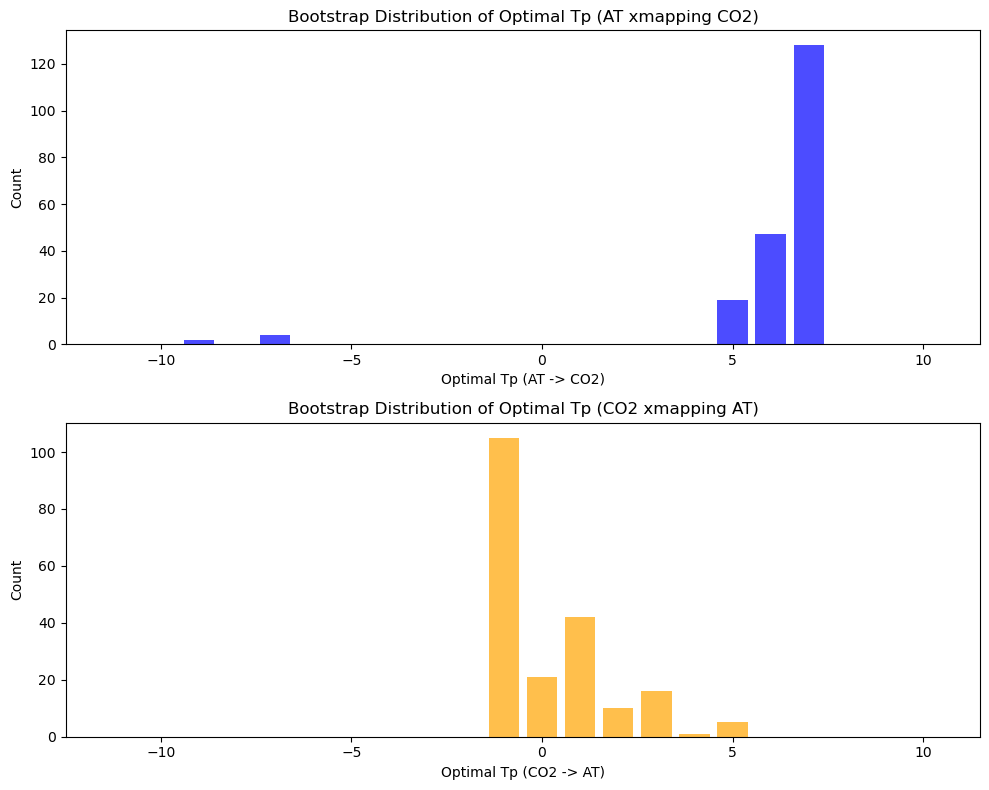

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyEDM import CCM

def bootstrap_ccm_Tp(df_AT, df_CO2, n_boot=200, sub_length=120, lib_size=90, Tp_range=range(-10, 11), tau=1, E=2):

    # Merge the two datasets on 'age'
    df = pd.merge(df_AT, df_CO2, on='age')
    # Rename 'age' to 'Time' (pyEDM expects a Time column)
    df = df.rename(columns={'age': 'Time'})
    
    n_total = len(df)
    forward_Tps = []
    reverse_Tps = []
    
    # Convert Tp_range to a list for indexing.
    Tp_list = list(Tp_range)
    
    # Perform bootstrap iterations
    for i in range(n_boot):
        # Select a random contiguous sub-sample of sub_length points.
        start = np.random.randint(0, n_total - sub_length + 1)
        sub_df = df.iloc[start:start+sub_length].reset_index(drop=True)
        
        forward_rho_tp = []
        reverse_rho_tp = []
        
        # Loop over Tp values in Tp_list.
        for Tp in Tp_list:
            # CCM: AT -> CO2
            ccm_forward = CCM(
                dataFrame   = sub_df,
                E           = E,
                tau         = tau,
                columns     = 'AT',    # predictor
                target      = 'CO2',   # target
                libSizes    = str(lib_size),  
                sample      = 100,
                random      = False,
                replacement = False,
                Tp          = Tp
            )
            # Append the CCM skill (rho) from the last library size entry.
            forward_rho_tp.append(ccm_forward.iloc[-1]['AT:CO2'])
            
            # CCM: CO2 -> AT
            ccm_reverse = CCM(
                dataFrame   = sub_df,
                E           = E,
                tau         = tau,
                columns     = 'CO2',   # predictor
                target      = 'AT',    # target
                libSizes    = str(lib_size),
                sample      = 1,
                random      = False,
                replacement = False,
                Tp          = Tp
            )
            reverse_rho_tp.append(ccm_reverse.iloc[-1]['CO2:AT'])
        
        # Determine the Tp that gives the maximum CCM skill for this iteration.
        best_forward_Tp = Tp_list[np.argmax(forward_rho_tp)]
        best_reverse_Tp = Tp_list[np.argmax(reverse_rho_tp)]
        forward_Tps.append(best_forward_Tp)
        reverse_Tps.append(best_reverse_Tp)
    
    return forward_Tps, reverse_Tps

# Run the bootstrap CCM test to obtain optimal Tp values.
forward_Tps, reverse_Tps = bootstrap_ccm_Tp(df_AT, df_CO2, n_boot=200, sub_length=120, lib_size=90, Tp_range=range(-10,11), tau=2, E=4)

# Plot histograms of the optimal Tp values.
plt.figure(figsize=(10,8))

plt.subplot(2, 1, 1)
plt.hist(forward_Tps, bins=np.arange(-11,12)-0.5, color='blue', alpha=0.7, rwidth=0.8)
plt.xlabel("Optimal Tp (AT -> CO2)")
plt.ylabel("Count")
plt.title("Bootstrap Distribution of Optimal Tp (AT xmapping CO2)")

plt.subplot(2, 1, 2)
plt.hist(reverse_Tps, bins=np.arange(-11,12)-0.5, color='orange', alpha=0.7, rwidth=0.8)
plt.xlabel("Optimal Tp (CO2 -> AT)")
plt.ylabel("Count")
plt.title("Bootstrap Distribution of Optimal Tp (CO2 xmapping AT)")

plt.tight_layout()
plt.show()
